## Real vs AI-generated Image Detection
In this notebook, we will explore the task of classifying images as real or AI-generated using fine-tuning techniques with several well-known RNN architectures. For this classification task, we will use the CIFAKE dataset, which includes both real and AI-generated images.

Link for the dataset: [CIFAKE: Real and AI-Generated Synthetic Images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import cv2
from tensorflow.keras.models import load_model
from keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

2024-06-17 10:34:23.885841: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 10:34:23.885974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 10:34:24.013392: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train"

# Load the dataset
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(32, 32)
)

Found 100000 files belonging to 2 classes.


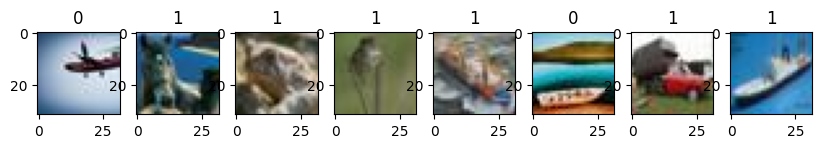

In [3]:
data_ir = data.as_numpy_iterator()
batch = data_ir.next()

fig, ax = plt.subplots(ncols = 8, figsize = (10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [4]:
data = data.map(lambda x, y : (x/225, y))

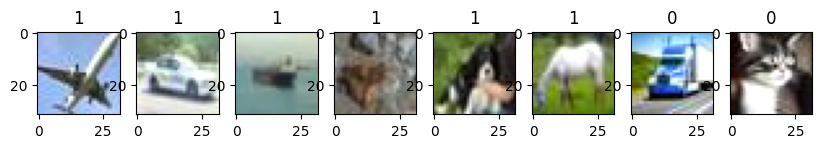

In [5]:
scaled_it = data.as_numpy_iterator()
batch = scaled_it.next()

fig, ax = plt.subplots(ncols = 8, figsize = (10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(float))
    ax[idx].title.set_text(batch[1][idx])

In [6]:
train_size = int(len(data) * 0.7)
cv_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1) + 1

train = data.take(train_size)
cv = data.skip(train_size).take(cv_size)
test = data.skip(train_size + cv_size).take(test_size)

print("Train: ", len(train))
print("Test: ", len(test))
print("Val: ", len(cv))

Train:  2187
Test:  313
Val:  625


In [7]:
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (32, 32, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

94765736/94765736 [==============================] - 0s 0us/step


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

In [9]:
#Learning rate scheduler
initial_learning_rate = 0.001
def lr_scheduler(epoch, lr):
    return lr * 0.95
lr_schedule = LearningRateScheduler(lr_scheduler)
optimizer = Adam(learning_rate = initial_learning_rate)

#Compiling the model
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [10]:
def augment_data(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = tf.image.random_brightness(x, max_delta = 0.1)
    x = tf.image.random_contrast(x, lower = 0.9, upper = 1.1)
    return x, y

train_augmented = data.map(augment_data)

In [11]:
# Early Stopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

# Train the model
history = model.fit(train_augmented, validation_data = cv, epochs = 10, callbacks = [lr_schedule, early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test)
print(f'Test Accuracy : {test_accuracy * 100:.2f}%')

Epoch 1/10


I0000 00:00:1718620613.062660     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 [==============================] - 198s 51ms/step - loss: 0.3440 - accuracy: 0.8541 - val_loss: 1.1315 - val_accuracy: 0.5614 - lr: 9.5000e-04
Epoch 2/10
3125/3125 [==============================] - 146s 47ms/step - loss: 0.2793 - accuracy: 0.8878 - val_loss: 4.3566 - val_accuracy: 0.8483 - lr: 9.0250e-04
Epoch 3/10
3125/3125 [==============================] - 148s 47ms/step - loss: 0.2257 - accuracy: 0.9106 - val_loss: 1.6841 - val_accuracy: 0.5472 - lr: 8.5737e-04
Epoch 4/10
3125/3125 [==============================] - 147s 47ms/step - loss: 0.2736 - accuracy: 0.8885 - val_loss: 0.2080 - val_accuracy: 0.9240 - lr: 8.1451e-04
Epoch 5/10
3125/3125 [==============================] - 149s 48ms/step - loss: 0.2171 - accuracy: 0.9137 - val_loss: 0.1818 - val_accuracy: 0.9251 - lr: 7.7378e-04
Epoch 6/10
3125/3125 [==============================] - 147s 47ms/step - loss: 0.2162 - accuracy: 0.9152 - val_loss: 2.1550 - val_accuracy: 0.5257 - lr: 7.3509e-04
Epoch 7/10
3125/3125 [=====

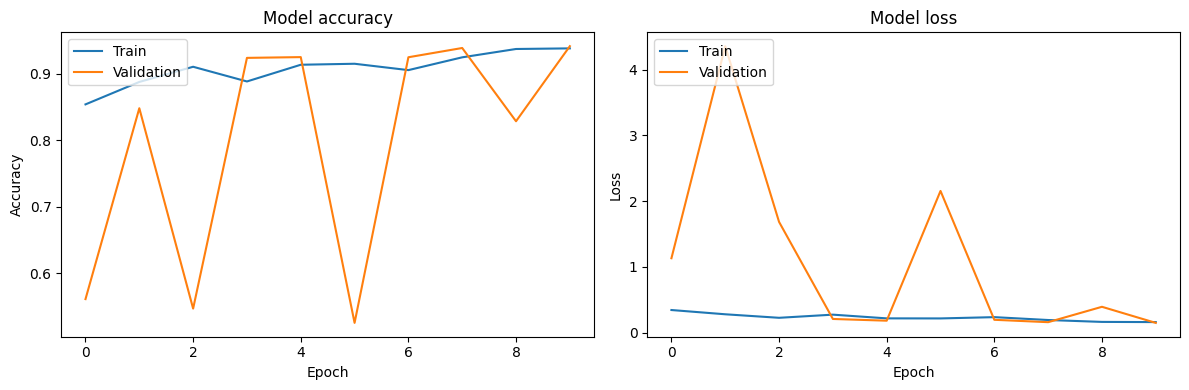

In [12]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [13]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 22ms/step


In [14]:
print(f'Precision: {pre.result().numpy()}, Recall: {rec.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.958519697189331, Recall: 0.9307008981704712, Accuracy: 0.9445886611938477


In [15]:
# Assuming 'model' is your Keras model
model.save('model/ai_imageclassifier', save_format='tf')

loaded_model = tf.keras.models.load_model('model/ai_imageclassifier')

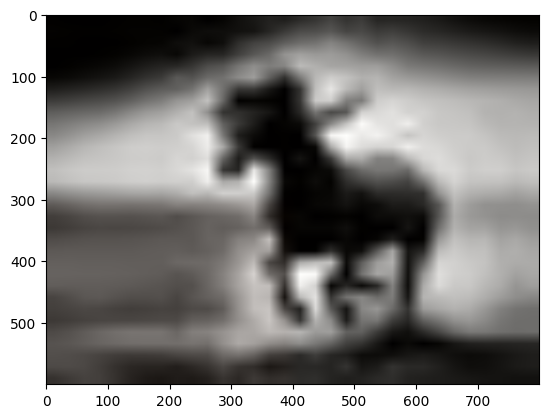

In [23]:
# Load the image
image_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/FAKE/0 (8).jpg'

try:
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not read the image from {image_path}")
    img = cv2.resize(img, (800, 600))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

except Exception as e:
    print(f"Error: {e}")

In [24]:
resize = tf.image.resize(img, (32, 32))
y_pred = model.predict(np.expand_dims(resize/255, 0))
y_pred

1/1 [==============================] - 0s 26ms/step


array([[3.3319047e-16]], dtype=float32)

In [25]:
if y_pred > 0.5:
    print(f'Predicted class: REAL')
else:
    print(f'Predicted class: AI')

Predicted class: AI


1/1 [==============================] - 0s 22ms/step


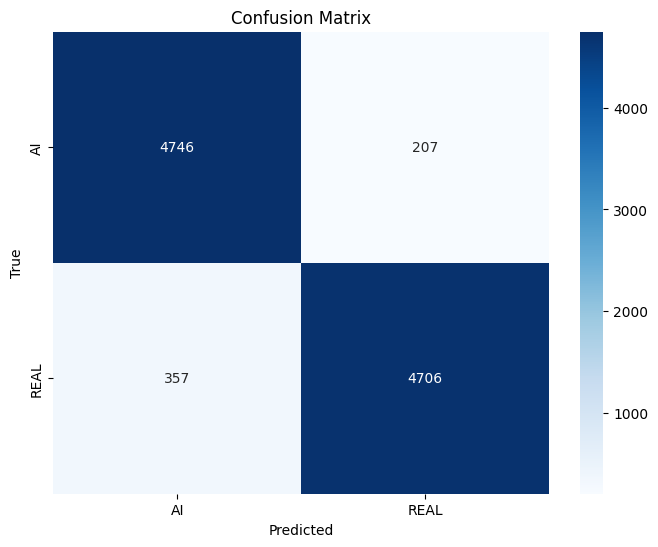

Classification Report:
               precision    recall  f1-score   support

          AI       0.93      0.96      0.94      4953
        REAL       0.96      0.93      0.94      5063

    accuracy                           0.94     10016
   macro avg       0.94      0.94      0.94     10016
weighted avg       0.94      0.94      0.94     10016



In [26]:
# Evaluate the model on the test set
y_true = []
y_pred_probs = []

for batch in test.as_numpy_iterator():
    X, y = batch
    y_true.extend(y)
    y_pred_probs.extend(model.predict(X).flatten())

# Convert probabilities to binary predictions
y_pred = np.array(y_pred_probs) > 0.5

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=['AI', 'REAL'])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'REAL'], yticklabels=['AI', 'REAL'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display Classification Report
print("Classification Report:\n", class_report)